In [3]:
import datasets
ds = datasets.load_from_disk("./taco_cleaned_exec_filtered_max75")
ds

Dataset({
    features: ['question', 'solutions', 'starter_code', 'input_output', 'difficulty', 'raw_tags', 'name', 'source', 'tags', 'skill_types', 'url', 'Expected Auxiliary Space', 'time_limit', 'date', 'picture_num', 'memory_limit', 'Expected Time Complexity'],
    num_rows: 7099
})

In [4]:
total_solns = 0
for ex in ds:
    total_solns += len(ex["solutions"])

total_solns

263704

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = ds.to_pandas()

difficulty_counts = df['difficulty'].value_counts()

order = ['EASY', 'MEDIUM', 'MEDIUM_HARD', 'HARD', 'VERY_HARD', 'UNKNOWN_DIFFICULTY']

ordered_difficulty_counts = pd.Series([difficulty_counts.get(level, 0) for level in order], index=order)

colors = ['#99ff99', '#66b3ff', '#ffcc99', '#ff9999', '#ffb3e6', '#c2c2f0']

plt.figure(figsize=(10, 6))
sns.barplot(x=ordered_difficulty_counts.index, y=ordered_difficulty_counts.values, palette=colors)
plt.title('Distribution of Problem Difficulties')
plt.xlabel('Difficulty Level')
plt.ylabel('Number of Problems')
plt.show()
plt.savefig("./plots/diff_distr.png")
plt.savefig("./plots/diff_distr.pdf")

In [ ]:
num_solutions = ds.to_pandas()['solutions'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(num_solutions, bins=30, color='skyblue')
plt.title('Distribution of Number of Solutions per Problem')
plt.xlabel('Number of Solutions')
plt.ylabel('Frequency')
plt.show()
plt.savefig("./plots/distr_solutions.png")
plt.savefig("./plots/distr_solutions.pdf")

In [ ]:
import sacrebleu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

tqdm.pandas(desc="Calculating BLEU Scores")

def average_bleu_scores(solutions):
    if len(solutions) < 2:
        return np.nan
    scores = []
    for i in range(len(solutions)):
        for j in range(i + 1, len(solutions)):
            reference = solutions[i]
            candidate = solutions[j]
            score = sacrebleu.raw_corpus_bleu([candidate], [[reference]], .01).score
            scores.append(score)
    return np.mean(scores)

df = ds.to_pandas()

df['bleu_scores'] = df['solutions'].progress_apply(average_bleu_scores)

plt.figure(figsize=(10, 6))
sns.histplot(df['bleu_scores'].dropna(), bins=30, color='purple')
plt.title('Average Pairwise BLEU Scores of Solutions')
plt.xlabel('Average BLEU Score')
plt.ylabel('Frequency')
plt.show()

In [ ]:
plt.savefig("./plots/bleu_between_solutions.png")
plt.savefig("./plots/bleu_between_solutions.pdf")

In [ ]:
from transformers import AutoTokenizer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.auto import tqdm

tqdm.pandas(desc="Tokenizing")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("bigcode/starcoder2-15b")

# Function to tokenize solutions and return token lengths
def get_token_lengths(solutions):
    token_lengths = []
    for solution in solutions:
        tokens = tokenizer.encode(solution, truncation=True, max_length=4096)
        token_lengths.append(len(tokens))
    return token_lengths

# Apply function to each list of solutions and flatten the result
all_token_lengths = [length for sublist in ds.to_pandas()['solutions'].progress_apply(get_token_lengths) for length in sublist]

# Convert to DataFrame for easier handling
token_lengths_df = pd.DataFrame(all_token_lengths, columns=['Token Lengths'])

# Basic statistics
min_length = token_lengths_df['Token Lengths'].min()
max_length = token_lengths_df['Token Lengths'].max()
mean_length = token_lengths_df['Token Lengths'].mean()
median_length = token_lengths_df['Token Lengths'].median()

print(f"Minimum token length: {min_length}")
print(f"Maximum token length: {max_length}")
print(f"Mean token length: {mean_length}")
print(f"Median token length: {median_length}")

# Plotting the distribution of token lengths
plt.figure(figsize=(12, 8))
sns.histplot(token_lengths_df['Token Lengths'], bins=50, color='orange')
plt.title('Distribution of Token Lengths in Solutions')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from transformers import AutoTokenizer
from tqdm.auto import tqdm

tqdm.pandas(desc="Tokenizing")

tokenizer = AutoTokenizer.from_pretrained("bigcode/starcoder2-15b")

def get_token_lengths(text):
    tokens = tokenizer.encode(text, truncation=True, max_length=2048)
    return len(tokens)

def process_solutions(solutions):
    return [get_token_lengths(solution) for solution in solutions]


question_token_lengths = ds.to_pandas()['question'].progress_apply(get_token_lengths)
solution_token_lengths = ds.to_pandas()['solutions'].progress_apply(process_solutions).explode()

combined_token_lengths = []
for question_length, solutions in zip(question_token_lengths, ds.to_pandas()['solutions']):
    combined_token_lengths.extend([question_length + len_ for len_ in process_solutions(solutions)])


Tokenizing:  18%|█████████████████████▏                                                                                               | 1284/7099 [00:01<00:05, 1050.56it/s]

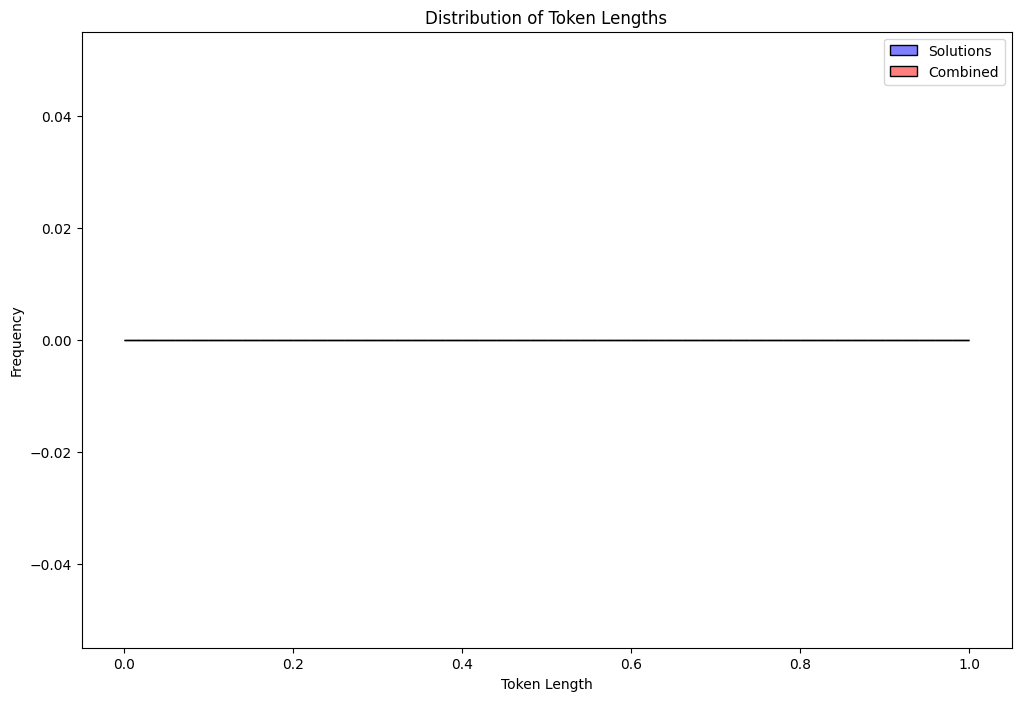

In [11]:
token_lengths_df = pd.DataFrame({
    'Solution Token Lengths': solution_token_lengths,
    'Question Token Lengths': question_token_lengths,
    'Combined Token Lengths': combined_token_lengths
})

plt.figure(figsize=(12, 8))
sns.histplot(token_lengths_df['Solution Token Lengths'], bins=50, color='blue', alpha=0.5, label='Solutions')
sns.histplot(token_lengths_df['Question Token Lengths'], bins=50, color='green', alpha=0.5, label='Questions')
sns.histplot(token_lengths_df['Combined Token Lengths'], bins=50, color='red', alpha=0.5, label='Combined')
plt.title('Distribution of Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()